# **HuBMAP + HPA - Hacking the Human Body**
##### **Segment multi-organ functional tissue units**

### **Importing necessary modules & packages**

In [1]:
# Importing EfficientNet models with intermediate endpoints
import sys
sys.path.append('../input/efficientnetv2-head-1x1-endpoint-v2/')
sys.path.append('../input/efficientnetv2-head-1x1-endpoint-v2/efficientnetv2/')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from sklearn import metrics
from sklearn.model_selection import KFold

import effnetv2_model
import re, os, io, time, pickle, math
import random, sys, cv2, gc, tifffile

2022-09-26 05:05:49.297497: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### **Seeding Random number generators**

In [3]:
def seed_all(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
SEED = 42
seed_all(SEED)

In [4]:
# Threshold to classify a pixel as mask
THRESHOLD = 0.1

DEBUG = False
IS_TPU = True

# Image dimensions
IMG_SIZE = 640
PATCH_SIZE = 640
N_CHANNELS = 3
N_PATCHES_PER_IMAGE = (IMG_SIZE // PATCH_SIZE) ** 2

INPUT_SHAPE = (PATCH_SIZE, PATCH_SIZE, N_CHANNELS)

# EfficientNet version
EFN_SIZE = 'b8'
LR_MAX = 0.02
EPOCHS = 30
MOMENTUM = 0.00

# Batch size
BATCH_SIZE = 64

# Dataset Mean and Standard Deviation
MEAN = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/MEAN.npy')
STD = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/STD.npy')

print(f'MEAN: {MEAN}, STD: {STD}')

MEAN: [0.16183016 0.18965785 0.1697808 ], STD: [0.1697331  0.19511677 0.175394  ]


### **Hardware Configuration**

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
     # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on GPU
REPLICAS: 1


### **FPN**

In [6]:
def FPN(xs, output_channels, last_layer, debug=False):
    def _conv(x):
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels * 2, 3, padding='SAME', kernel_initializer='he_normal', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels, 3, padding='SAME', kernel_initializer='he_normal')(x)
        x = tf.image.resize(x, size=target_size, method=tf.image.ResizeMethod.BILINEAR)
        x = tf.nn.relu(x)
        return x

    target_size = last_layer.shape[1:3]
    xs = tf.keras.layers.Concatenate()([_conv(x) for x in xs])
    x = tf.keras.layers.Concatenate()([xs, last_layer])

    if debug:
        return x, xs
    else:
        return x

### **ASPP**

In [7]:
def ASPP(x, mid_c=320, dilations=[1, 2, 3, 4], out_c=640, debug=False):
    def _aspp_module(x, filters, kernel_size, padding, dilation, groups=1):
        x = tf.keras.layers.ZeroPadding2D(padding=padding)(x)
        x = tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation,
                groups=1 if IS_TPU else groups,
                kernel_initializer='he_uniform',
            )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        
        return x
    
    x0 = tf.math.reduce_max(x, axis=(1,2), keepdims=True)
    x0 = tf.keras.layers.Conv2D(filters=mid_c, kernel_size=1, strides=1, kernel_initializer='he_uniform', use_bias=False)(x0)
    x0 = tf.keras.layers.BatchNormalization(gamma_initializer=tf.constant_initializer(value=0.25))(x0)
    x0 = tf.nn.relu(x0)
                                  
                                  
    xs = (
        [_aspp_module(x, mid_c, 1, padding=0, dilation=1)] +
        [_aspp_module(x, mid_c, 3, padding=d, dilation=d, groups=4) for d in dilations]
    )
    
    x0= tf.image.resize(x0, size=xs[0].shape[1:3])
    x = tf.keras.layers.Concatenate()([x0] + xs)
    x = tf.keras.layers.Conv2D(filters=out_c, kernel_size=1, kernel_initializer='he_uniform', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
                       
    if debug:
        return x, x0, xs
    else:
        return x

### **Upsample**

In [8]:
def PixelShuffle(x, upscale_factor=2):
    _, w, h, c = x.shape
    n = -1

    c_out = c // upscale_factor ** 2
    w_out = w * upscale_factor
    h_out = h * upscale_factor

    x = tf.reshape(x, [-1, upscale_factor, upscale_factor, w, h, c_out])
    x = tf.transpose(x, [0, 3, 1, 4, 2, 5])
    x = tf.reshape(x, [-1, w_out, h_out, c_out])

    return x

In [9]:
# Inspiration: https://www.tensorflow.org/tutorials/generative/pix2pix#build_an_input_pipeline_with_tfdata
def upsample(x, concat, target_filters, name, conv2dt_kernel_init_max, relu=True, dropout=0, debug=False):
#     x = PixelShuffle(x)

    filters = concat.shape[-1]
    x_up = tf.keras.layers.Conv2DTranspose(
            filters, # Number of Convolutional Filters
            kernel_size=4, # Kernel Size
            strides=2, # Kernel Steps
            padding='SAME', # linear scaling
            name=f'Conv2DTranspose_{name}', # Name of Layer
            kernel_initializer='he_uniform',
            use_bias=False,
        )(x)
    
    concat = tf.keras.layers.BatchNormalization(
        gamma_initializer=tf.constant_initializer(value=0.25),
        name=f'BatchNormalization_{name}'
    )(concat)
    x = tf.keras.layers.Concatenate(name=f'Concatenate_{name}')([x_up, concat])
    x = tf.nn.relu(x)
    
        
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', activation='relu', name=f'Conv2D_1_{name}')(x)
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', name=f'Conv2D_2_{name}')(x)
    
    if relu:
        x = tf.nn.relu(x)
    
    x = tf.keras.layers.Dropout(dropout, name=f'Dropout_{name}')(x)

    if debug:
        return x, x_up, concat
    else:
        return x

### **Model**

In [10]:
def get_model(dropout_decoder=0, dropout_cnn=0, file_path=None, lr=1e-3, eps=1e-7, clipnorm=5.0, wd_coef=1e-2, cnn_trainable=True):
    with strategy.scope():
        # EfficientNetV2 Backbone # 
        cnn = effnetv2_model.get_model(f'efficientnet-{EFN_SIZE}', include_top=False, weights=None, model_config={ 'conv_dropout': dropout_cnn })
        cnn.trainable = cnn_trainable

        # Inputs, note the names are equal to the dictionary keys in the dataset
        image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.float32)
        image_norm = tf.cast(image, tf.float32) / 255
        image_norm = tf.keras.layers.experimental.preprocessing.Normalization(mean=MEAN, variance=STD, dtype=tf.float32)(image_norm)

        embedding, up6, up5, up4, up3, up2, up1 = cnn(image_norm, with_endpoints=True)
        print(f'embedding shape: {embedding.shape} up1 shape: {up1.shape}, up2 shape: {up2.shape}')
        print(f'up3 shape: {up3.shape}, up4 shape: {up4.shape}, up5 shape: {up5.shape}, up6 shape: {up6.shape}')
        
        dec0 = ASPP(up2)
        dec0 = tf.keras.layers.Dropout(0.50)(dec0)

        dec1 = upsample(dec0, up3, up4.shape[-1] * 4, 'upsample1', 0.02, dropout=dropout_decoder)
        dec2 = upsample(dec1, up4, up5.shape[-1] * 2, 'upsample2', 0.02, dropout=dropout_decoder)
        dec3 = upsample(dec2, up5, up6.shape[-1] * 2, 'upsample3', 0.02)
        dec4 = upsample(dec3, up6, 64, 'upsample4', 0.02)
        
        print(f'dec0 shape: {dec0.shape}, dec1 shape: {dec1.shape}, dec2 shape: {dec2.shape}, dec3 shape: {dec3.shape}, dec4 shape: {dec4.shape}')
        
        dec_fpn = FPN([dec0, dec1, dec2, dec3], 32, dec4)
        
        print(f'dec_fpn shape: {dec_fpn.shape}')
        
        # Head
        x = tf.keras.layers.Dropout(0.10)(dec_fpn)
        x = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=1,
            padding='SAME',
            kernel_initializer=tf.random_normal_initializer(0.00, 0.05),
            activation='sigmoid',
            name='Conv2D_3_head'
        )(x)
        output = tf.image.resize(x, size=[IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BILINEAR)
        
        model = tf.keras.models.Model(inputs=image, outputs=output)

        if file_path:
            print('Loading pretrained weights...')
            model.load_weights(file_path)
            
        model.trainable = False

        return model

In [11]:
# Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
model = get_model(file_path='../input/hubmap-training-tf-tpu-efficientnet-b8-640640-p/model_0.h5')

2022-09-26 05:05:56.445098: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-26 05:05:56.449197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-26 05:05:56.543870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 05:05:56.548128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-09-26 05:05:56.548182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-26 05:05:56.590464: I tensorflow/stream_executor/platform/def

embedding shape: (None, 2816) up1 shape: (None, 20, 20, 2816), up2 shape: (None, 20, 20, 704)
up3 shape: (None, 40, 40, 248), up4 shape: (None, 80, 80, 88), up5 shape: (None, 160, 160, 56), up6 shape: (None, 320, 320, 32)
dec0 shape: (None, 20, 20, 640), dec1 shape: (None, 40, 40, 352), dec2 shape: (None, 80, 80, 112), dec3 shape: (None, 160, 160, 64), dec4 shape: (None, 320, 320, 64)
dec_fpn shape: (None, 320, 320, 192)
Loading pretrained weights...


In [12]:
# plot model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 640, 640, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 640, 640, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 640, 640, 3)  7           tf.math.truediv[0][0]            
______________________________________________________________________________________________

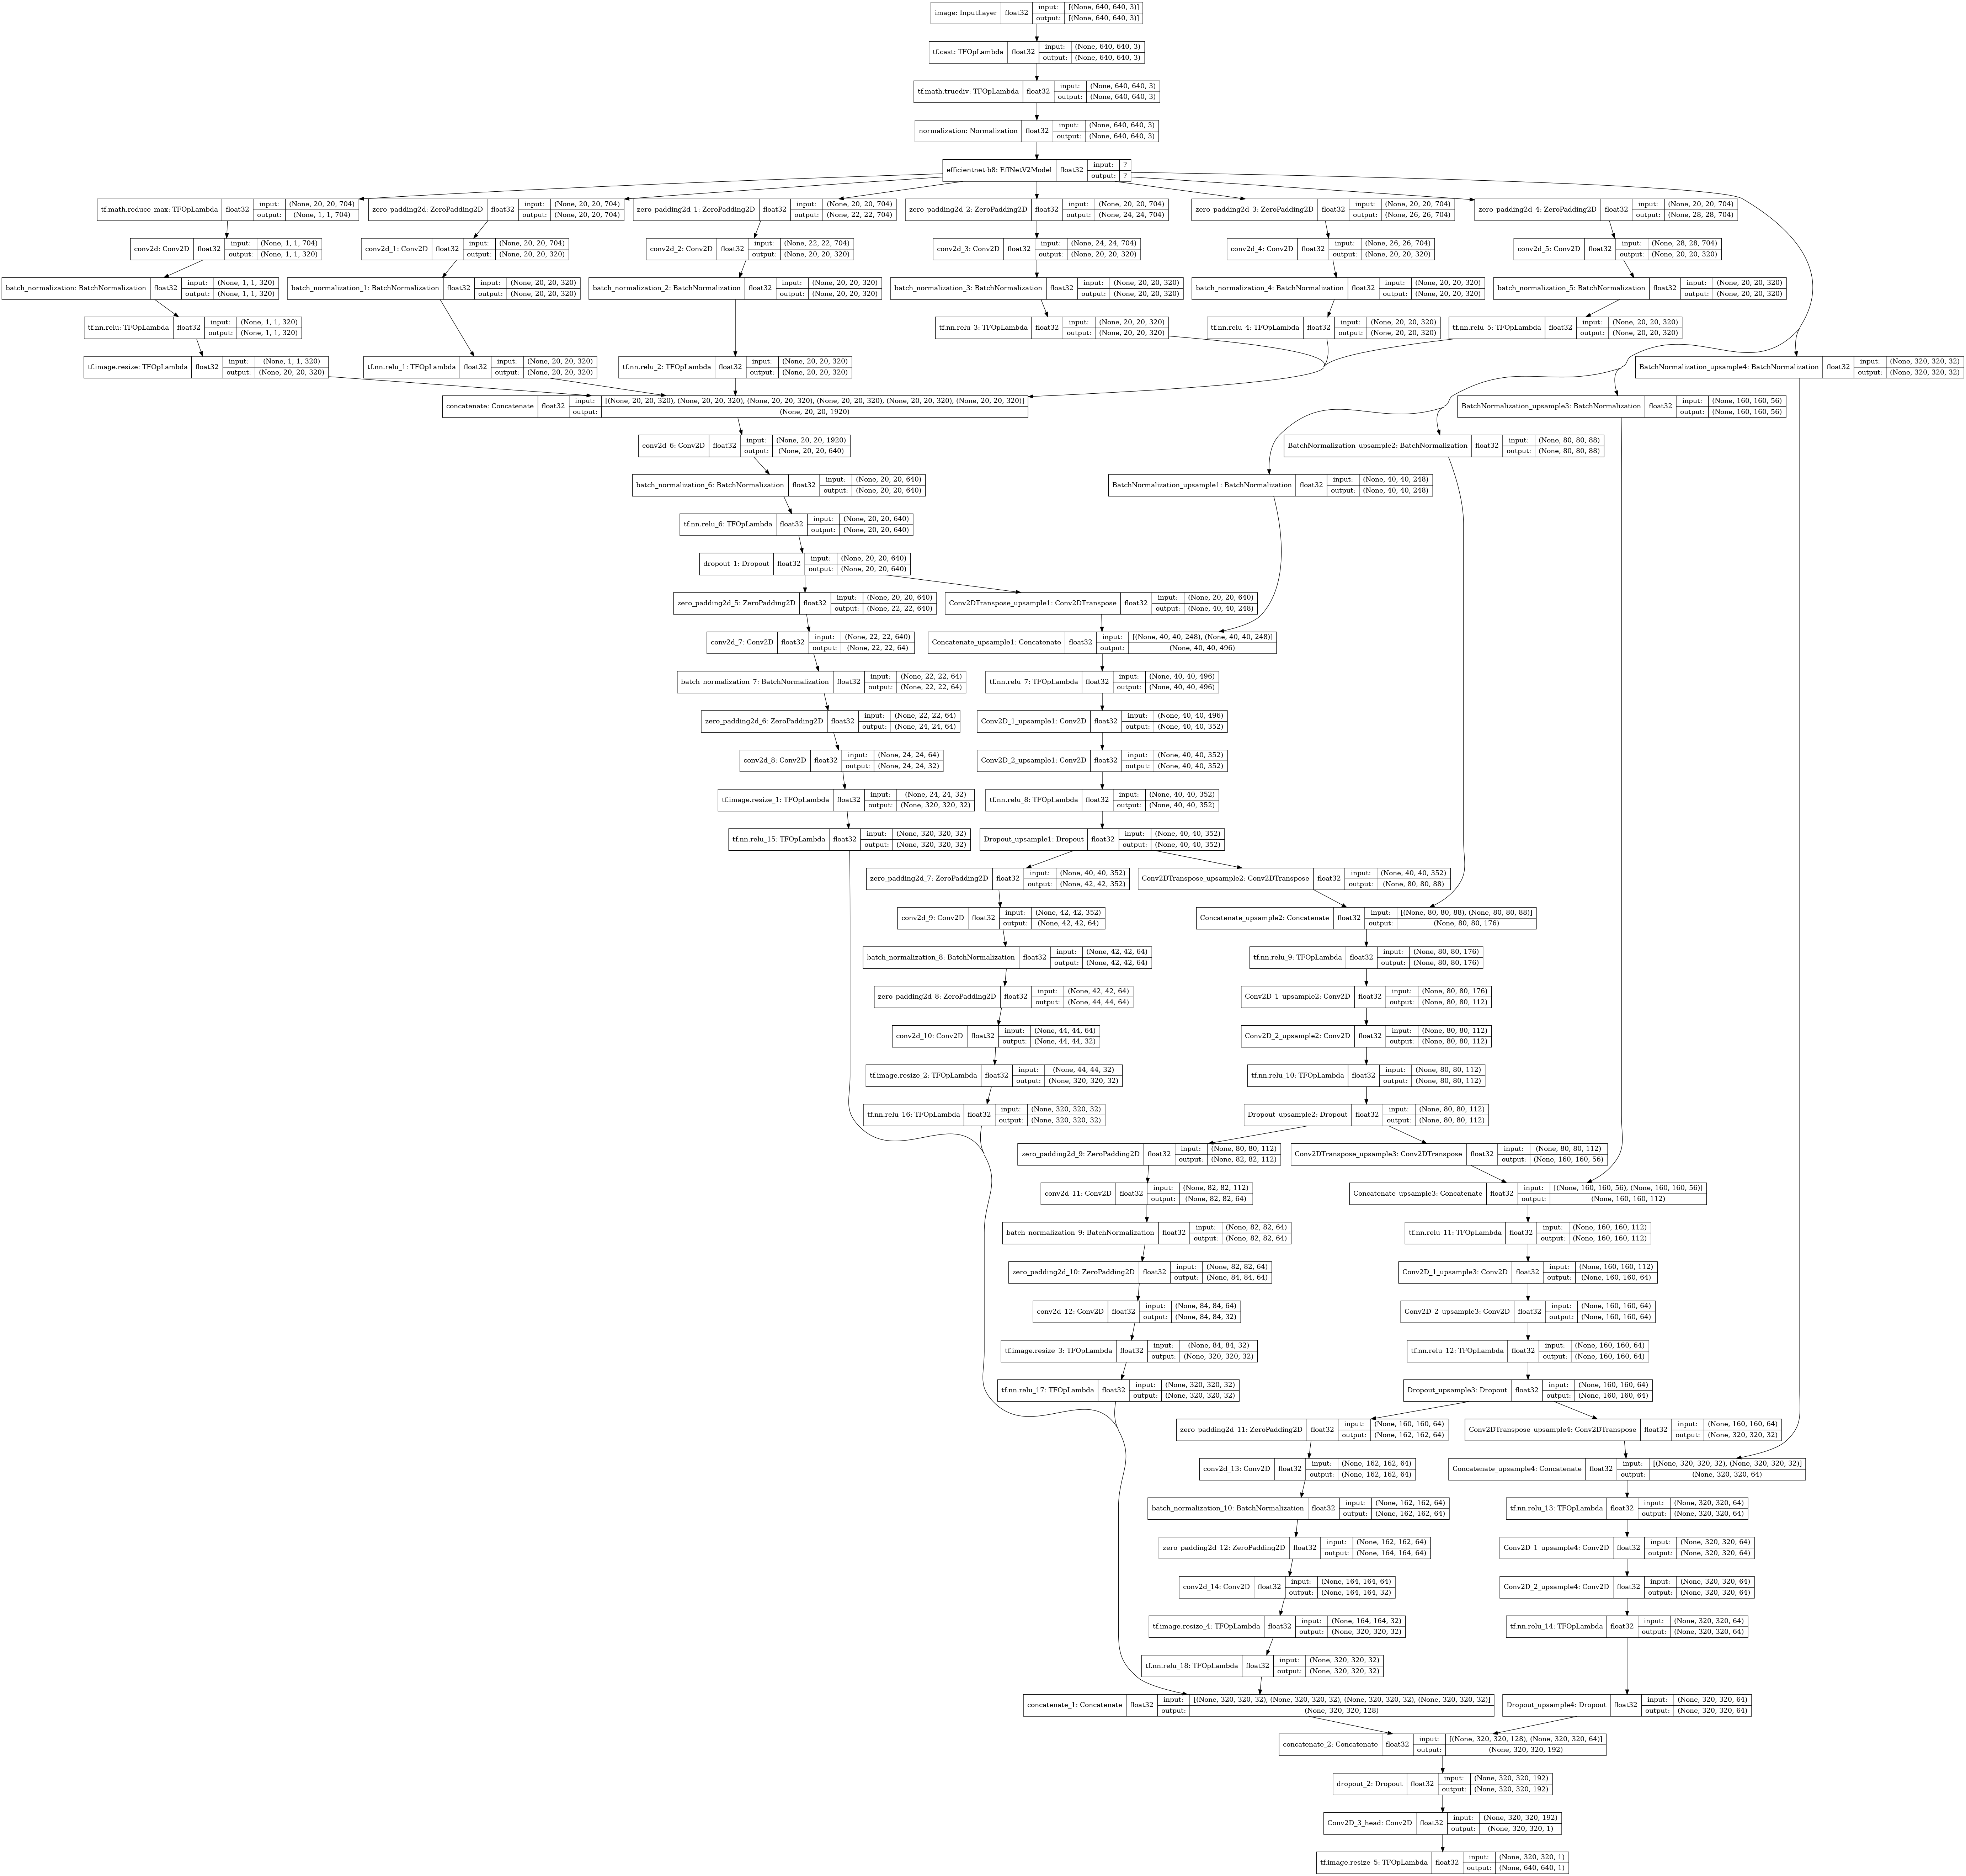

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

### **Utility Funtions**

In [14]:
# Resized a tensor to the specified size
def resize_tensor(tensor, size=IMG_SIZE, dtype=np.uint8):
    return cv2.resize(tensor, [size, size], interpolation=cv2.INTER_CUBIC).astype(dtype)

In [15]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def get_mask(image_id):
    row = train.loc[train['id'] == image_id].squeeze()
    h, w = row[['img_height', 'img_width']]
    mask = np.zeros(shape=[h * w], dtype=np.uint8)
    s = row['rle'].split()
    starts, lengths = [ np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2]) ]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        mask[lo : hi] = 1
        
    mask = mask.reshape([h, w]).T
        
    mask = resize_tensor(mask)
    
    mask = np.expand_dims(mask, axis=2)
        
    return mask

In [16]:
# Reads an image and returns the image and original image size
def get_image(image_id, folder, negative=True):
    image = tifffile.imread(f'/kaggle/input/hubmap-organ-segmentation/{folder}_images/{image_id}.tiff')
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    # Image Size
    image_size, _, _ = image.shape
    
    # Reverse pixels to make tissue colored and background black
    if negative:
        image = image - image.min()
        image = image / (image.max() - image.min())
        image = image * 255
        image = 255 - image.astype(np.uint8)
        
    # Resize
    image = resize_tensor(image)
    return image, image_size

In [17]:
# extract patches from image
def extract_patches(image):
    _, _, c = image.shape
    image = tf.expand_dims(image, 0)
    image_patches = tf.image.extract_patches(image, [1,PATCH_SIZE,PATCH_SIZE,1], [1, PATCH_SIZE, PATCH_SIZE, 1], [1, 1, 1, 1], padding='SAME')
    image_patches = tf.reshape(image_patches, [N_PATCHES_PER_IMAGE, PATCH_SIZE, PATCH_SIZE, c])
    image_patches = image_patches.numpy()

    return image_patches

In [18]:
def rle_encode_less_memory(img):
    # transpose image
    pixels = img.T.flatten()
    pixels[0], pixels[-1] = 0, 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

### **Inference**

In [19]:
# training DataFrame
train = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')
# test DataFrame
test = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/test.csv')

In [20]:
# reconstruct original image from patches
def merge_patches(patches):
    image = np.zeros(shape=[IMG_SIZE, IMG_SIZE, patches.shape[-1]], dtype=patches.dtype)
    s = int(N_PATCHES_PER_IMAGE ** 0.50)
    for r in range(s):
        for c in range(s):
            start_x = r * PATCH_SIZE
            end_x = (r + 1) * PATCH_SIZE
            start_y = c * PATCH_SIZE
            end_y = (c + 1) * PATCH_SIZE
            image[start_x:end_x, start_y:end_y] = patches[r * s + c]
            
    return image

### **Test**

  0%|          | 0/10 [00:00<?, ?it/s]

2022-09-26 05:06:33.360106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-26 05:06:33.374878: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-09-26 05:06:43.712357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-09-26 05:06:50.511835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-26 05:06:51.722091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


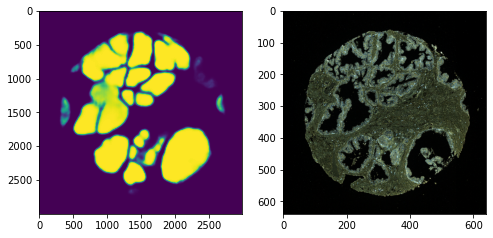

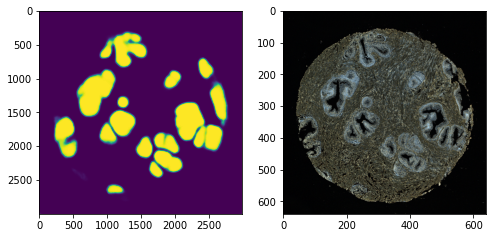

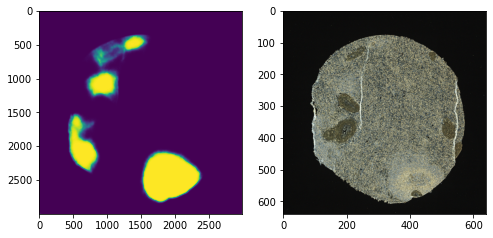

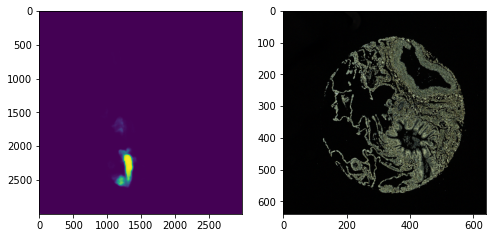

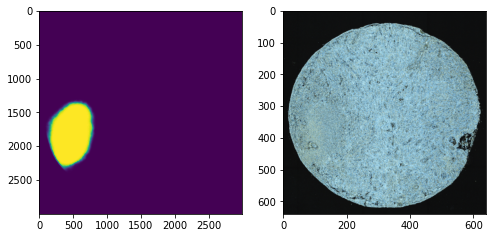

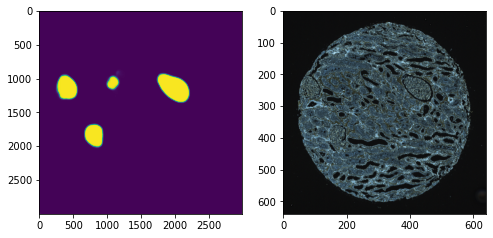

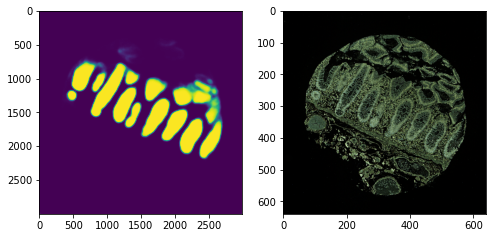

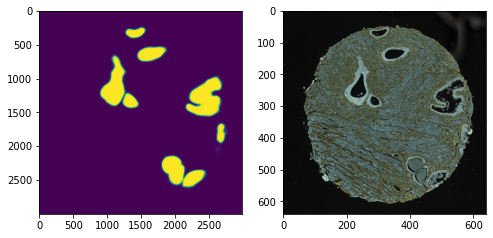

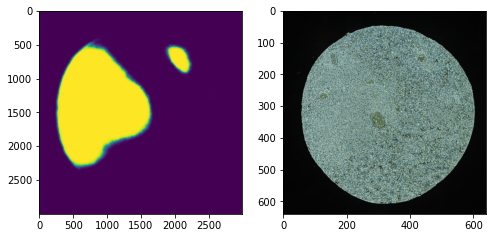

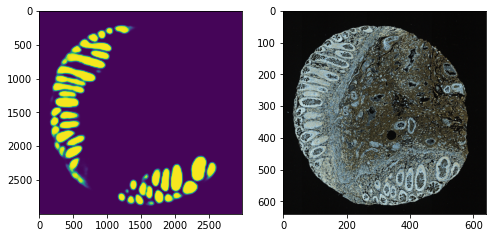

In [21]:
# verify the trained weights are correctly loaded on 10 predictions
test_rows = []
N = 10

for row_idx, row in tqdm(train[:N].iterrows(), total=N):
    # preprocess image
    image, image_size = get_image(row['id'], 'train')
    image_patches = extract_patches(image)
    
    # prediction
    mask_patches_pred = model.predict(image_patches)
    mask_pred = merge_patches(mask_patches_pred)
    mask_pred_resized = resize_tensor(mask_pred, size=image_size, dtype=np.float32)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(mask_pred_resized)
    axes[1].imshow(image)
    plt.show()
        
    mask_binary = (mask_pred_resized > THRESHOLD).astype(np.int8)
    test_rows.append({
        'id': row['id'],
        'rle': rle_encode_less_memory(mask_binary)
    })

### **Inference Loop**

  0%|          | 0/1 [00:00<?, ?it/s]

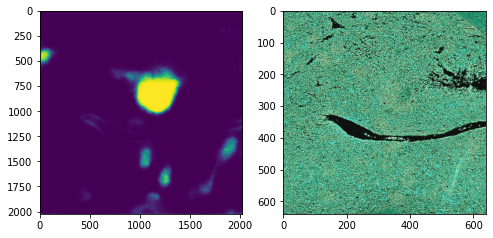

In [22]:
# store predictions in list of dictionaries
test_rows = []
for row_idx, row in tqdm(test.iterrows(), total=len(test)):
    # preprocess image
    image, image_size = get_image(row['id'], 'test')
    image_patches = extract_patches(image)
    
    # prediction
    mask_patches_pred = model.predict(image_patches)
    # merge patches & resize mask to original size
    mask_pred = merge_patches(mask_patches_pred)
    mask_pred_resized = resize_tensor(mask_pred, size=image_size, dtype=np.float32)
    
    if row_idx == 0:
        fig, axes = plt.subplots(1,2, figsize=(8,4))
        axes[0].imshow(mask_pred_resized)
        axes[1].imshow(image)
        plt.show()
        
    # resize and binarize mask
    mask_binary = (mask_pred_resized > THRESHOLD).astype(np.int8)
    test_rows.append({
        'id': row['id'],
        'rle': rle_encode_less_memory(mask_binary)
    })

### **Submission**

In [23]:
test_df = pd.DataFrame(test_rows)
test_df.to_csv('submission.csv', index=False)